## Naive Bayes Classifier

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsdata = fetch_20newsgroups(subset='train')
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [2]:
# Naive Bayes Classifier를 위해서 BoW로 만들어줘야함.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB # 다항분포 나이브 베이즈 모델
from sklearn.metrics import accuracy_score

dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(newsdata.data)
print(x_train_dtm.shape)

(11314, 130107)


In [3]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(11314, 130107)


In [4]:
mod = MultinomialNB()
mod.fit(tfidfv, newsdata.target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)
x_test_dtm = dtmvector.transform(newsdata_test.data)
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

predicted = mod.predict(tfidfv_test)
print(accuracy_score(newsdata_test.target, predicted))

0.7738980350504514


## BiLSTM for text classification

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x1db9bdbf0d0>)

In [12]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
total_data

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
...,...,...
99995,0,한글화해주면 10개산다
99996,0,개쌉노잼 ㅋㅋ
99997,0,노잼이네요... 30분하고 지웠어요...
99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.


In [13]:
# count unique values
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

In [14]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)
total_data

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
...,...,...
99995,0,한글화해주면 10개산다
99996,0,개쌉노잼 ㅋㅋ
99997,0,노잼이네요... 30분하고 지웠어요...
99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.


In [15]:
total_data.isnull().sum()

label      0
reviews    0
dtype: int64

In [16]:
train_data, test_data = train_test_split(total_data, test_size=0.2, random_state=42)

In [17]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True) # 공백이 생기면 nan값으로 바꿔서 확인
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


C:\Users\Myeong\AppData\Local\Temp\ipykernel_11164\2754427533.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [18]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 19979


C:\Users\Myeong\AppData\Local\Temp\ipykernel_11164\2684537507.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [19]:
mecab = Mecab(dicpath='c:/Users/Myeong/mecab-ko-dic')

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)

In [21]:
x_train = train_data['tokenized'].values
y_train = train_data['label'].values

x_test = test_data['tokenized'].values
y_test = test_data['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [22]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq += value

    if (value < threshold):
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 33769
등장 빈도가 1번 이하인 희귀 단어의 수: 14192
단어 집합에서 희귀 단어의 비율: 42.02671088868489
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.8323802485645078


In [23]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19579


In [24]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [28]:
for i in x_train:
    print(len(i))
    break

6


max length of reviews :  86
average length of revies :  21.33557744046651


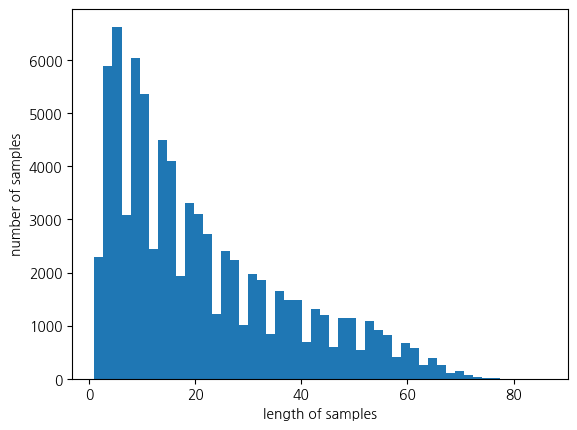

In [30]:
print('max length of reviews : ', max(len(review) for review in x_train))
print('average length of revies : ', sum(map(len, x_train))/len(x_train))
plt.hist([len(review) for review in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count += 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (count/len(nested_list)) * 100))

In [34]:
max_len = 70
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 70 이하인 샘플의 비율 : 99.84733397569858


In [35]:
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [36]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=15, batch_size=256, validation_split=0.2)

Epoch 1/15
250/250 [==============================] - 8s 15ms/step - loss: 0.5343 - acc: 0.7358 - val_loss: 0.4655 - val_acc: 0.7835
Epoch 2/15
250/250 [==============================] - 3s 12ms/step - loss: 0.4351 - acc: 0.8024 - val_loss: 0.4539 - val_acc: 0.7891
Epoch 3/15
250/250 [==============================] - 3s 12ms/step - loss: 0.4066 - acc: 0.8187 - val_loss: 0.4656 - val_acc: 0.7848
Epoch 4/15
250/250 [==============================] - 3s 12ms/step - loss: 0.3861 - acc: 0.8295 - val_loss: 0.4454 - val_acc: 0.7944
Epoch 5/15
250/250 [==============================] - 3s 12ms/step - loss: 0.3634 - acc: 0.8414 - val_loss: 0.4580 - val_acc: 0.7888
Epoch 6/15
250/250 [==============================] - 3s 12ms/step - loss: 0.3438 - acc: 0.8515 - val_loss: 0.4655 - val_acc: 0.7905
Epoch 7/15
250/250 [==============================] - 3s 12ms/step - loss: 0.3218 - acc: 0.8626 - val_loss: 0.4599 - val_acc: 0.7960
Epoch 8/15
250/250 [==============================] - 3s 12ms/step - 

In [37]:
print('accuracy %.4f'%(model.evaluate(x_test, y_test)[1]))

625/625 [==============================] - 3s 5ms/step - loss: 0.7257 - acc: 0.7599
accuracy 0.7599


In [39]:
model.evaluate(x_test, y_test)

625/625 [==============================] - 3s 5ms/step - loss: 0.7257 - acc: 0.7599


[0.7257002592086792, 0.7598978877067566]

In [40]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [41]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

1/1 [==============================] - 0s 485ms/step
99.95% 확률로 부정 리뷰입니다.


In [42]:
sentiment_predict('케릭터가 예뻐서 좋아요')

1/1 [==============================] - 0s 21ms/step
92.61% 확률로 부정 리뷰입니다.


In [43]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')

1/1 [==============================] - 0s 21ms/step
70.50% 확률로 긍정 리뷰입니다.
